# Task 3 QSVM

Generate a Quantum Support Vector Machine (QSVM) using the iris dataset and try to propose a kernel from a parametric quantum circuit to classify the three classes(setosa, versicolor, virginica) using the one-vs-all format, the kernel only works as binary class;pification. Identify the proposal with the lowest number of qubits and depth to obtain higher accuracy. You can use the UU† format or using the Swap-Test.

In [1]:
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasemts import load_iris
from sklearn.preprocessing import MinMaxScaler
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pennylane as qml
import seaborn as sns
from sklearn.svm import SVC
import matplotlib as mpl
from abc import abstractmethod, ABC

import warnings
import time

import torch
from torchvision import datasets, transforms
from torch import manual_seed
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import pandas as pd
from utils import ova_random, ova_trained, get_scores

np.random.seed(100)

In [2]:
iris_data = load_iris()
X = iris_data.data
Y = iris_data.target

X = np.pad(X, ((0,0),(0,2)))

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
X_train.shape, X_test.shape

((90, 6), (60, 6))

In [3]:
def feature_map(x, params, n_layers, n_wires):
    """The embedding ansatz"""

    steps = x.shape[0]//3
    qubits = list(range(n_wires))
    
    for q in qubits:
        qml.Hadamard(wires=q)
    
    for l in range(n_layers):
        for q in qubits:
            for i in range(steps):
                z = x[3*i:3*i+3]*params[l,q,0,3*i:3*i+3] + params[l,q,1,3*i:3*i+3]
                qml.RZ(z[0], wires=q)
                qml.RY(z[1], wires=q)
                qml.RZ(z[2], wires=q)
                
        if (l & 1):
            for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
                qml.CZ((q0,q1))
        else:
            for q0, q1 in zip(qubits[0::2], qubits[1::2]):
                qml.CZ((q0,q1))

In [4]:
def ansatz(x, params, n_layers, n_wires):
    feature_map(x, params, n_layers, n_wires)
    return qml.probs(wires=range(n_wires))

In [62]:
n_l = 2
n_w = 4
in_shape = 3

params_shape = (n_l,n_w,2,in_shape)
random_input = np.random.uniform(0, 2 * np.pi, (in_shape,), requires_grad=True)
random_params = np.random.uniform(0, 2 * np.pi, params_shape, requires_grad=True)
print(qml.draw(qml.QNode(ansatz, device=qml.device('default.qubit', n_w)))(random_input, random_params, n_l, n_w))

0: ──H──RZ(26.54)──RY(6.94)──RZ(27.18)─╭●──RZ(34.98)──RY(7.90)──RZ(10.63)────╭Z─┤ ╭Probs
1: ──H──RZ(20.11)──RY(6.35)──RZ(18.14)─╰Z──RZ(33.72)──RY(7.05)──RZ(6.89)──╭●─│──┤ ├Probs
2: ──H──RZ(17.14)──RY(7.68)──RZ(22.64)─╭●──RZ(11.87)──RY(9.20)──RZ(5.86)──╰Z─│──┤ ├Probs
3: ──H──RZ(25.66)──RY(8.97)──RZ(4.99)──╰Z──RZ(33.86)──RY(3.82)──RZ(20.04)────╰●─┤ ╰Probs


In [6]:
n_layers = [1,2,3,4]
n_wires = [1,2,3,4]

In [7]:
svm_dict = {
    'n_layers': [],
    'n_wires': [],
    'train_f1_score': [],
    'test_f1_score': [],
    'runtime': []
}

for l in n_layers:
    for q in n_wires:
        print(f"layer {l}, qubits {q}")
        
        start = time.time()
        params_shape = (l, q, 2, 6)
        
        svms = ova_random(X_train, y_train, X_test, y_test, feature_map, l, q, params_shape)
        train_f1_score, test_f1_score = get_scores(svms, X_train, y_train, X_test, y_test)
        end = time.time()
        
        svm_dict['n_layers'].append(l)
        svm_dict['n_wires'].append(q)
        svm_dict['train_f1_score'].append(train_f1_score)
        svm_dict['test_f1_score'].append(test_f1_score)
        svm_dict['runtime'].append(end-start)
        
        pd.DataFrame(svm_dict).to_csv('ova_random.csv')

layer 1, qubits 1
class 0
The accuracy of the kernel for class 0 with random parameters is 0.800
The accuracy of the kernel for class 0 with random parameters is 0.850
class 1
The accuracy of the kernel for class 1 with random parameters is 0.944
The accuracy of the kernel for class 1 with random parameters is 0.917
class 2
The accuracy of the kernel for class 2 with random parameters is 0.811
The accuracy of the kernel for class 2 with random parameters is 0.850
F1 score on train set: 0.844
F1 score on test set: 0.900
layer 1, qubits 2
class 0
The accuracy of the kernel for class 0 with random parameters is 1.000
The accuracy of the kernel for class 0 with random parameters is 1.000
class 1
The accuracy of the kernel for class 1 with random parameters is 0.967
The accuracy of the kernel for class 1 with random parameters is 0.933
class 2
The accuracy of the kernel for class 2 with random parameters is 0.922
The accuracy of the kernel for class 2 with random parameters is 0.883
F1 scor

The accuracy of the kernel for class 2 with random parameters is 0.989
The accuracy of the kernel for class 2 with random parameters is 0.917
F1 score on train set: 1.000
F1 score on test set: 0.950


In [63]:
df = pd.read_csv('ova_random.csv')
df

,Unnamed: 0,n_layers,n_wires,train_f1_score,test_f1_score,runtime
0,0,1,1,0.844444,0.900000,160.787332
1,1,1,2,0.977778,0.933333,280.326425
2,2,1,3,0.966667,0.966667,399.226291
3,3,1,4,0.966667,0.950000,518.140158
4,4,2,1,0.722222,0.700000,259.957465
5,5,2,2,0.977778,0.950000,539.446384
6,6,2,3,0.977778,0.966667,850.032568
7,7,2,4,0.966667,0.950000,1098.913788
8,8,3,1,0.744444,0.566667,432.943743
9,9,3,2,0.900000,0.883333,770.823735


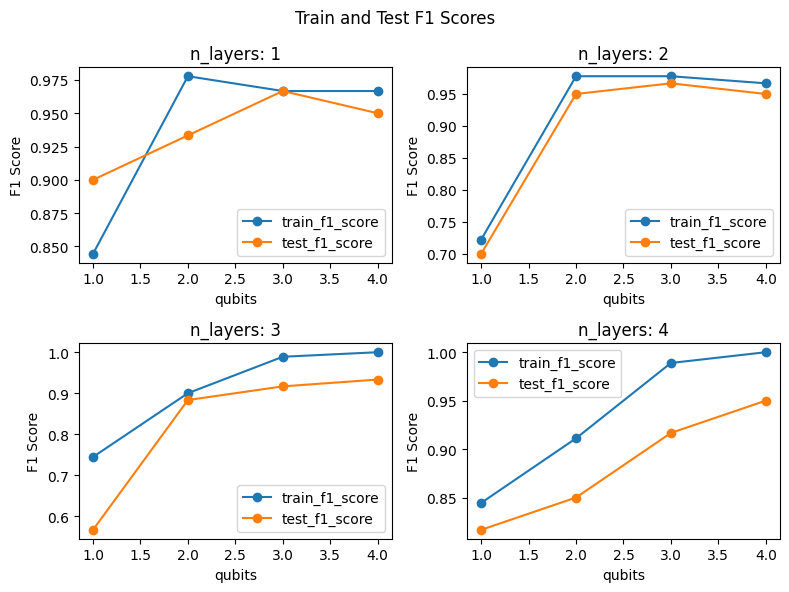

In [64]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 6)

for i in range(2):
    for j in range(2):
        n_l = i*2 + j + 1
        df[df['n_layers'] == n_l].plot(kind = 'line', 
                                     x = 'n_wires', 
                                     y = 'train_f1_score', 
                                     marker = 'o', 
                                     ax = axs[i, j])
        df[df['n_layers'] == n_l].plot(kind = 'line', 
                                     x = 'n_wires', 
                                     y = 'test_f1_score', 
                                     marker = 'o', 
                                     ax = axs[i, j])
        axs[i, j].set_title(f"n_layers: {n_l}")

for ax in axs.flat:
    ax.set(xlabel='qubits', ylabel='F1 Score')
#     ax.label_outer()
    
fig.suptitle('Train and Test F1 Scores')
fig.tight_layout()

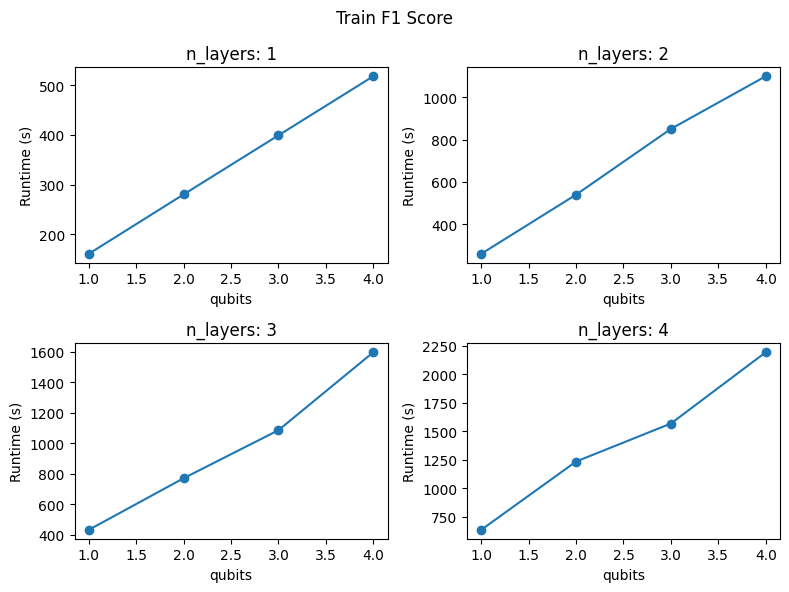

In [65]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 6)

for i in range(2):
    for j in range(2):
        n_l = i*2 + j + 1
        df[df['n_layers'] == n_l].plot(kind = 'line', 
                                     x = 'n_wires', 
                                     y = 'runtime', 
                                     marker = 'o', 
                                     ax = axs[i, j])
        axs[i, j].get_legend().remove()
        axs[i, j].set_title(f"n_layers: {n_l}")

for ax in axs.flat:
    ax.set(xlabel='qubits', ylabel='Runtime (s)')
#     ax.label_outer()

fig.suptitle('Train F1 Score')
fig.tight_layout()